In [1]:
##################################
#                                #
# regression_Trillium.ipynb      #
# Created 2024-11-25             #
# Akhil Garg, akhil@akhilgarg.ca #
#                                #
##################################

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import pickle
import os
import itertools

from sklearn import preprocessing
from sklearn import pipeline
from sklearn import linear_model
from sklearn import metrics
from datetime import datetime

import matplotlib.pyplot as plt

#pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
imputation_file = '2024-12-10 AMR_imputation_Trillium.xlsx'

data = pd.read_excel(imputation_file)

# From data point 5172 onwards
#data = data[5172:]

# Only use data from 2022 onwards
data = data[data['Year']>=2022]

data

,AgeCat,Sex,FINAL,Year,ADMIT_SVC,Acquisition,RecentHospitalization,ClinicalESBL,PriorGNOrg,PriorAMG,...,Daptomycin_PGNO_imp,Vancomycin_PGNO_imp,Linezolid_PGNO_imp,Amikacin_PGNO_imp,Tobramycin_PGNO_imp,Gentamicin_PGNO_imp,Clindamycin_PGNO_imp,Doxycycline_PGNO_imp,Erythromycin_PGNO_imp,TMPSMX_PGNO_imp
0,75-80,F,Escherichia coli,2023,Medical,Community,0,0,not_applicable,NaN,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
1,>90,M,Escherichia coli,2022,Medical,Community,0,0,not_applicable,NaN,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
5,85-90,M,Klebsiella pneumoniae,2023,Medical,Community,1,0,not_applicable,NaN,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
10,70-75,F,Klebsiella pneumoniae,2022,Medical,Community,0,0,not_applicable,NaN,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
12,70-75,M,Proteus mirabilis,2022,Surgical,Community,0,0,not_applicable,NaN,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8966,65-70,M,Klebsiella pneumoniae,2022,Medical,Community,0,0,not_applicable,NaN,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
8967,70-75,M,Escherichia coli,2023,Medical,Community,1,1,Citrobacter freundii,NaN,...,RESISTANT,no_data,RESISTANT,SUSCEPTIBLE,SUSCEPTIBLE,SUSCEPTIBLE,RESISTANT,no_data,RESISTANT,SUSCEPTIBLE
8971,70-75,M,Enterobacter cloacae,2022,Surgical,Hospital,0,0,not_applicable,NaN,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
8972,>90,F,Escherichia coli,2022,Medical,Community,0,0,not_applicable,NaN,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable


In [3]:
# List of output antibiotics
output_antibiotics = ['Penicillin_FINAL_imp','Amoxiclav_FINAL_imp','Ampicillin_FINAL_imp','Cloxacillin_FINAL_imp','Piptaz_FINAL_imp','Cefazolin_FINAL_imp','Ceftriaxone_FINAL_imp','Ceftazidime_FINAL_imp','Ertapenem_FINAL_imp','Meropenem_FINAL_imp','Ciprofloxacin_FINAL_imp','Levofloxacin_FINAL_imp','Moxifloxacin_FINAL_imp','Daptomycin_FINAL_imp','Vancomycin_FINAL_imp','Linezolid_FINAL_imp','Amikacin_FINAL_imp','Tobramycin_FINAL_imp','Gentamicin_FINAL_imp','Clindamycin_FINAL_imp','Doxycycline_FINAL_imp','Erythromycin_FINAL_imp','TMPSMX_FINAL_imp']
output_antibiotics = ['Meropenem_FINAL_imp','Piptaz_FINAL_imp','Ceftazidime_FINAL_imp','Ceftriaxone_FINAL_imp','Ciprofloxacin_FINAL_imp','Tobramycin_FINAL_imp']

# Missingness susceptibilities for each antibiotic
print('Missingness')
for abx in output_antibiotics:
    missingness = data[data[abx]=='no_data'].shape[0] / data.shape[0]
    print('{:<15} {:>6.2f}%'.format(abx.split('_')[0],missingness*100))
    
# Piperacillin-tazobactam or tobramycin missingness
print('{:<15} {:>6.2f}%'.format('Piptaz or tobra',
      data[(data['Piptaz_FINAL_imp']=='no_data')|(data['Tobramycin_FINAL_imp']=='no_data')].shape[0]/data.shape[0]*100))

Missingness
Meropenem         0.48%
Piptaz            0.35%
Ceftazidime       0.13%
Ceftriaxone       0.77%
Ciprofloxacin     1.39%
Tobramycin        0.11%
Piptaz or tobra   0.38%


In [4]:
# Find instances where prior gram negative organisms did not have any susceptibilities reported
# e.g. quality improvement project where catheterized urine cultures did not report susceptibilities

#output_PGNO_antibiotics = ['Meropenem_PGNO_imp','Piptaz_PGNO_imp','Ceftazidime_PGNO_imp','Ceftriaxone_PGNO_imp','Ciprofloxacin_PGNO_imp','Tobramycin_PGNO_imp']

# Remove rows where all of the prior GNO susceptibilities are "no_data"
#data = data[(data[output_PGNO_antibiotics]!='no_data').all(axis='columns')]

#data

## Preprocessing

In [5]:
# Add a column for hospital site 
data['hosp_Sunnybrook'] = 0
data['hosp_TOH'] = 0
data['hosp_Trillium'] = 1

In [6]:
# Change missing data in the final output imputation to be resistant
data[output_antibiotics] = data[output_antibiotics].replace('no_data','RESISTANT')

# Convert susceptible/intermediate/resistant to numerical categorical values
data = data.replace({'SUSCEPTIBLE':0,'INTERMEDIATE':1,'RESISTANT':1})

# Convert age to a continuous variable
age_categories = {'<40'  :30, 
                  '40-45':42.5,
                  '45-50':47.5,
                  '50-55':52.5,
                  '55-60':57.5,
                  '60-65':62.5,
                  '65-70':67.5,
                  '70-75':72.5,
                  '75-80':77.5,
                  '80-85':82.5,
                  '85-90':87.5,
                  '>90'  :95
                 }
data['Age'] = data['AgeCat'].replace(age_categories).infer_objects()

# Rename acquisition locations to match future code
data['Acquisition'] = data['Acquisition'].replace({'Community':'community','Hospital':'ward'})

# Rename admitting service to match future code
data['ADMIT_SVC'] = data['ADMIT_SVC'].replace({'Medical':'medical','Surgical':'surgical'})

# Convert prior antibiotics from name to binary 1/0
data.loc[:,'PriorAMG':'PriorOtherAbx'] = data.loc[:,'PriorAMG':'PriorOtherAbx'].map(
    lambda s: 0 if pd.isna(s) else 1)

# One hot encode categories
one_hot_data = pd.get_dummies(data, columns=['Sex','Acquisition','ADMIT_SVC'],
                                        prefix= ['sex','acquisition','adm_service'])

### Encode prior antibiotic exposure

In [7]:
# Create a column of prior exposure to either penicillins or aminoglycosides
conditions = [((one_hot_data['PriorPenicillin']==0) & (one_hot_data['PriorAMG']==0)),
              ((one_hot_data['PriorPenicillin']==1) | (one_hot_data['PriorAMG']==1))]
# default -1 value should not occur, and is an error-checking mechanism
one_hot_data['PriorPenicillin_or_AMG'] = np.select(conditions, [0,1], default=-1)

# Create new categories of "prior non-[antibiotic class]"
one_hot_data['PriorNonCephalosporin'] = one_hot_data[['PriorAMG','PriorCarbapenem','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
one_hot_data['PriorNonCarbapenem'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
one_hot_data['PriorNonPenicillin'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonFQ'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonAMG'] = one_hot_data[['PriorFQ','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonOtherAbx'] = one_hot_data[['PriorFQ','PriorAMG','PriorCephalosporin','PriorPenicillin','PriorCarbapenem']].any(axis='columns')

one_hot_data['PriorNonPenicillin_or_AMG'] = one_hot_data[['PriorFQ','PriorCephalosporin','PriorCarbapenem']].any(axis='columns')

### List of antibiotics and classes to run regression on


In [8]:
antibiotic_list = ['Cefazolin','Ceftriaxone','Ceftazidime','Piptaz','Meropenem','Ciprofloxacin','Tobramycin','TMPSMX']

# New antibiotic list as of 2024-03-26:
antibiotic_list = ['Meropenem','Piptaz','Ceftazidime','Ceftriaxone','Ciprofloxacin']

antibiotic_classes = {'Cefazolin':'Cephalosporin','Ceftriaxone':'Cephalosporin','Ceftazidime':'Cephalosporin',
                      'Piptaz':'Penicillin','Meropenem':'Carbapenem','Ciprofloxacin':'FQ','Tobramycin':'AMG',
                      'TMPSMX':'OtherAbx','Piptaz_or_Tobramycin':'Penicillin_or_AMG'}

In [9]:
# Add a column for combined pip-taz and tobramycin via multiplication    
# (would only be 1 (resistant) if both are 1 (resistant), otherwise 0 (susceptible))
one_hot_data['Piptaz_or_Tobramycin_FINAL_imp'] = (one_hot_data['Piptaz_FINAL_imp'])*(one_hot_data['Tobramycin_FINAL_imp'])

### Handling previous antibiotic exposure and resistance

In [10]:
# Look for antibiotic resistance during previous gram negative infection
def previous_infection(priorGNOrg,prior_susceptibility):
    '''
    For a given antibiotic, takes a previous gram negative organism and its susceptibility as input
    Outputs:
        0 if no previous gram negative organism
        0 if previous gram negative organism without susceptibility data
        1 if previous susceptible gram negative organism
        2 if previous resistant gram negative organism 
    '''
    
    if priorGNOrg=='not_applicable': return 0
    elif prior_susceptibility=='no_data': return 0

    # 0 = prior susceptible, 1 = prior resistant
    elif (priorGNOrg!='not_applicable') and (prior_susceptibility==0): return 1
    elif (priorGNOrg!='not_applicable') and (prior_susceptibility==1): return 2
        
    else: raise ValueError('Inputs passed to the previous_infection function are invalid.')

# Add a column for previous susceptibility to the particular antibiotic
for antibiotic in antibiotic_list:
    one_hot_data[antibiotic+'Resistance'] = one_hot_data.apply(lambda x: previous_infection(x['PriorGNOrg'],x[antibiotic+'_PGNO_imp']), axis=1)

In [11]:
# Special case of piperacillin-tazobactam plus tobramycin

    # 0 if no previous gram negative organism
    # 0 if previous gram negative organism without susceptibility data for either antibiotic
    # 1 if previous resistance to only one of the two antibiotics (the other may be susceptible or have no data)
    # 2 if previous resistance to both antibiotics

# Note that this behaviour is slightly different from the function for single antibiotic susceptibility histories,
    # which would assign a 1 if the previous antibiotic was susceptible

# 0 = prior susceptible, 1 = prior resistant
conditions = [(one_hot_data['PriorGNOrg']=='not_applicable'),              
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']==0)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']==0)),  
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']==1)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']==0)),
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']==1)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']==1))]
values = [0,0,0,0,0,1,1,1,1,2]
# default -1 value should not occur, and is an error-checking mechanism
one_hot_data['Piptaz_or_TobramycinResistance'] = np.select(conditions, values, default=-1)

# if 'Piptaz_or_Tobramycin' not in antibiotic_list:
#     antibiotic_list.append('Piptaz_or_Tobramycin')

In [12]:
# Convert prior resistance history into one-hot encoding

for antibiotic in antibiotic_list:
    one_hot_data[antibiotic+'Resistance'] = one_hot_data[antibiotic+'Resistance'].replace({0:'no_prior',
                                                                                           1:'susceptible',
                                                                                           2:'nonsusceptible'
                                                                                          })
    one_hot_data = pd.get_dummies(one_hot_data,columns=[antibiotic+'Resistance'])

### Organisms isolated

In [13]:
one_hot_data['FINAL'].value_counts()

FINAL
Escherichia coli                               2571
Pseudomonas aeruginosa                          808
Klebsiella pneumoniae                           717
Proteus mirabilis                               298
Enterobacter cloacae                            261
Klebsiella oxytoca                              139
Klebsiella aerogenes                            120
Serratia marcescens                              83
Klebsiella variicola                             80
Citrobacter koseri                               75
Stenotrophomonas maltophilia                     71
Citrobacter freundii                             64
Morganella morganii                              56
Proteus vulgaris                                 14
Acinetobacter calcoaceticus / baumannii          12
Providencia rettgeri                              9
Citrobacter amalonaticus                          9
Achromobacter xylosoxidans ssp xylosoxidans       8
Salmonella enterica serovar typhi                 7
Acinet

# Regression Function

In [14]:
regression_inputs = ['Age','sex_M',
                     'acquisition_ICU','acquisition_ward',
                     'adm_service_surgical',
                     'RecentHospitalization',
                     
                     'Prior[Class]Exposure','Prior[NonClass]Exposure',
                     '[Antibiotic]_susceptible','[Antibiotic]_nonsusceptible',
                     
                     'ClinicalESBL']

print('Number of regression inputs: {}'.format(len(regression_inputs)))

Number of regression inputs: 11



Logistic regression model for Meropenem:

Logistic Regression Coefficients
MeropenemResistance_nonsusceptible          2.5828
acquisition_ICU                             1.3356
PriorCarbapenem                             1.3112
PriorNonCarbapenem                          1.0626
acquisition_ward                            0.8424
sex_M                                       0.2349
RecentHospitalization                       0.0044
Age                                        -0.0127
ClinicalESBL                               -0.0759
MeropenemResistance_susceptible            -0.1964
adm_service_surgical                       -0.2676

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.18
                     median:  0.99
                     mean:    0.96
                     max:     1.00
                     
Resistant isolates   min:     0.13
                     median:  0.86
                     mean:    0.76
                     max:     0.99
          

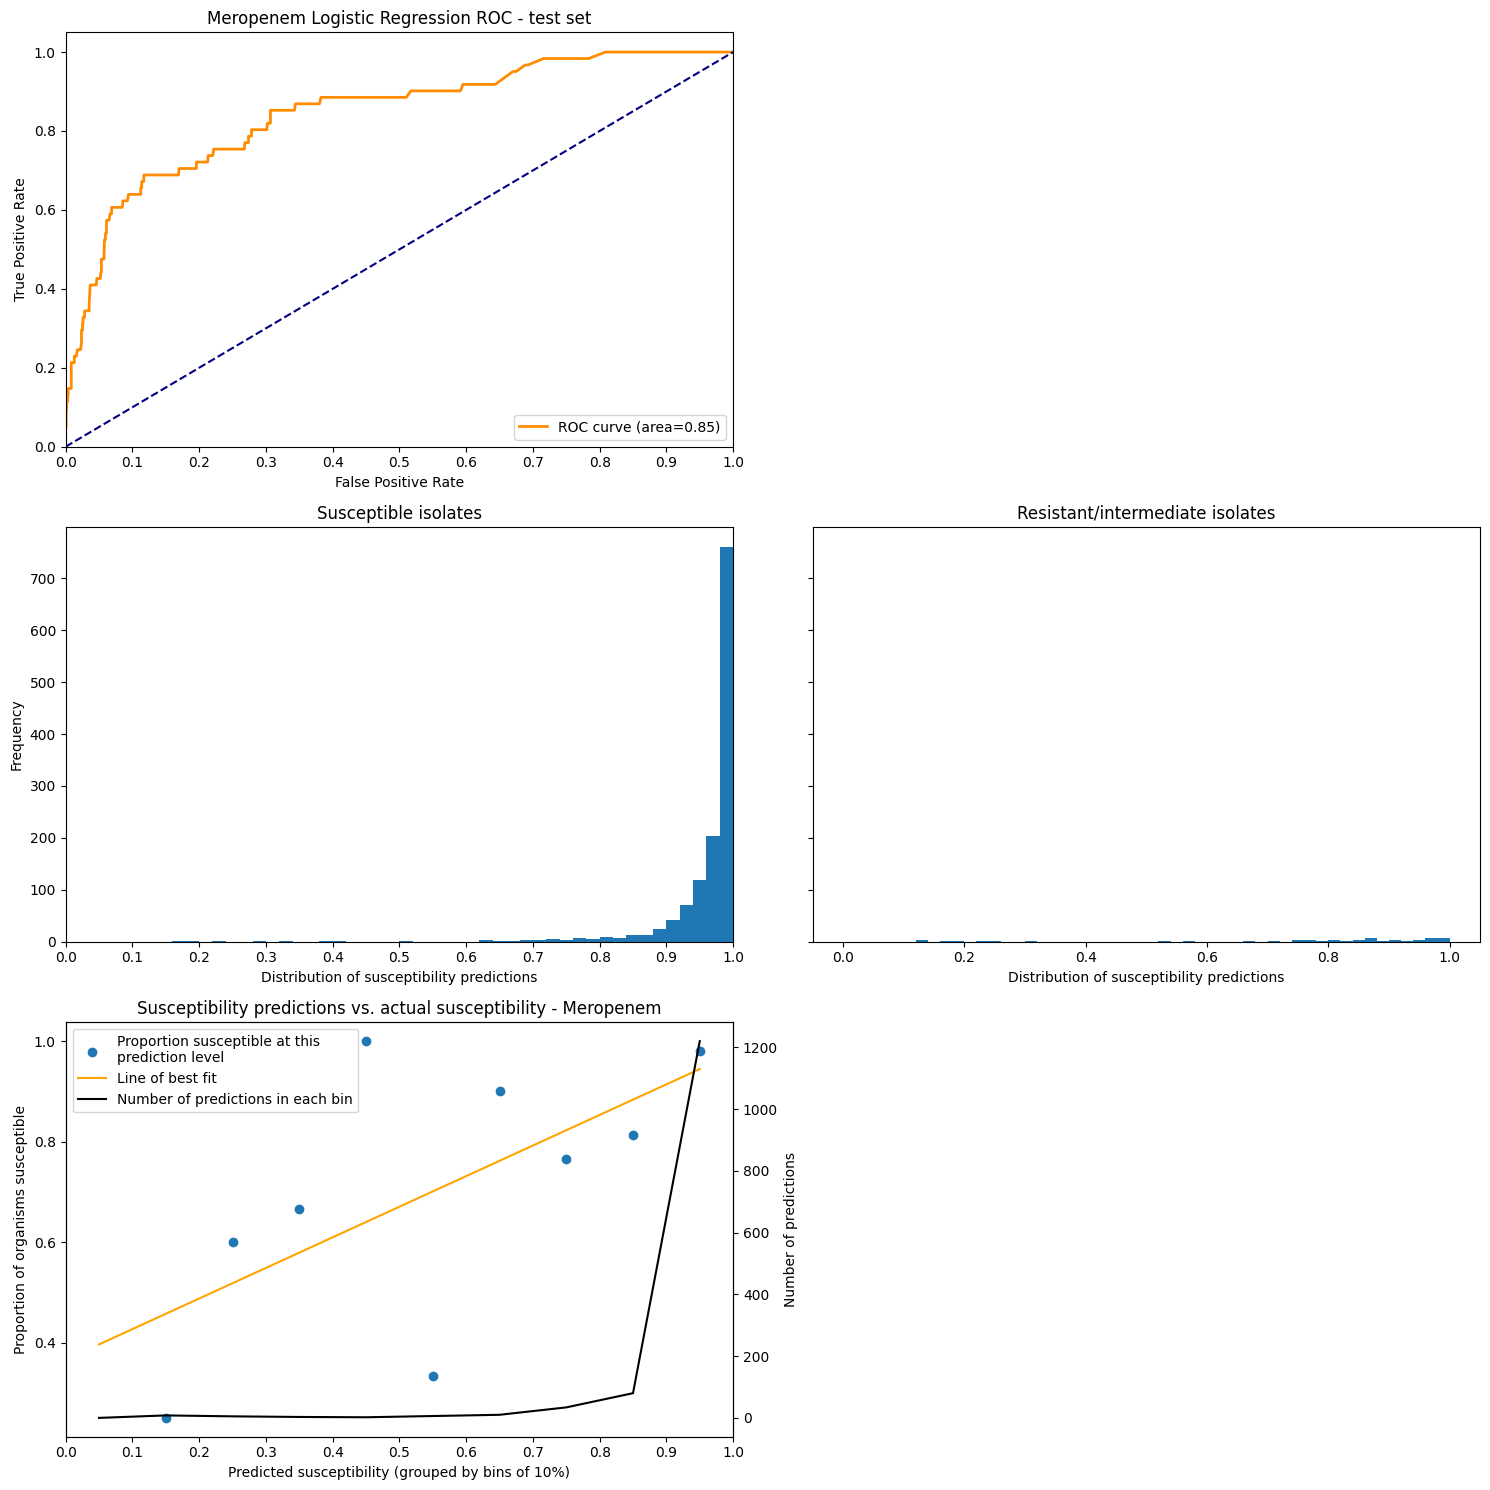


Logistic regression model for Piptaz:

Logistic Regression Coefficients
ClinicalESBL                                1.5972
PiptazResistance_nonsusceptible             1.3238
PriorNonPenicillin                          0.7838
acquisition_ICU                             0.3741
sex_M                                       0.2488
PriorPenicillin                             0.1069
adm_service_surgical                        0.0824
acquisition_ward                            0.0194
Age                                        -0.0060
RecentHospitalization                      -0.0078
PiptazResistance_susceptible               -0.8209

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.06
                     median:  0.80
                     mean:    0.75
                     max:     0.92
                     
Resistant isolates   min:     0.07
                     median:  0.68
                     mean:    0.62
                     max:     0.91
             

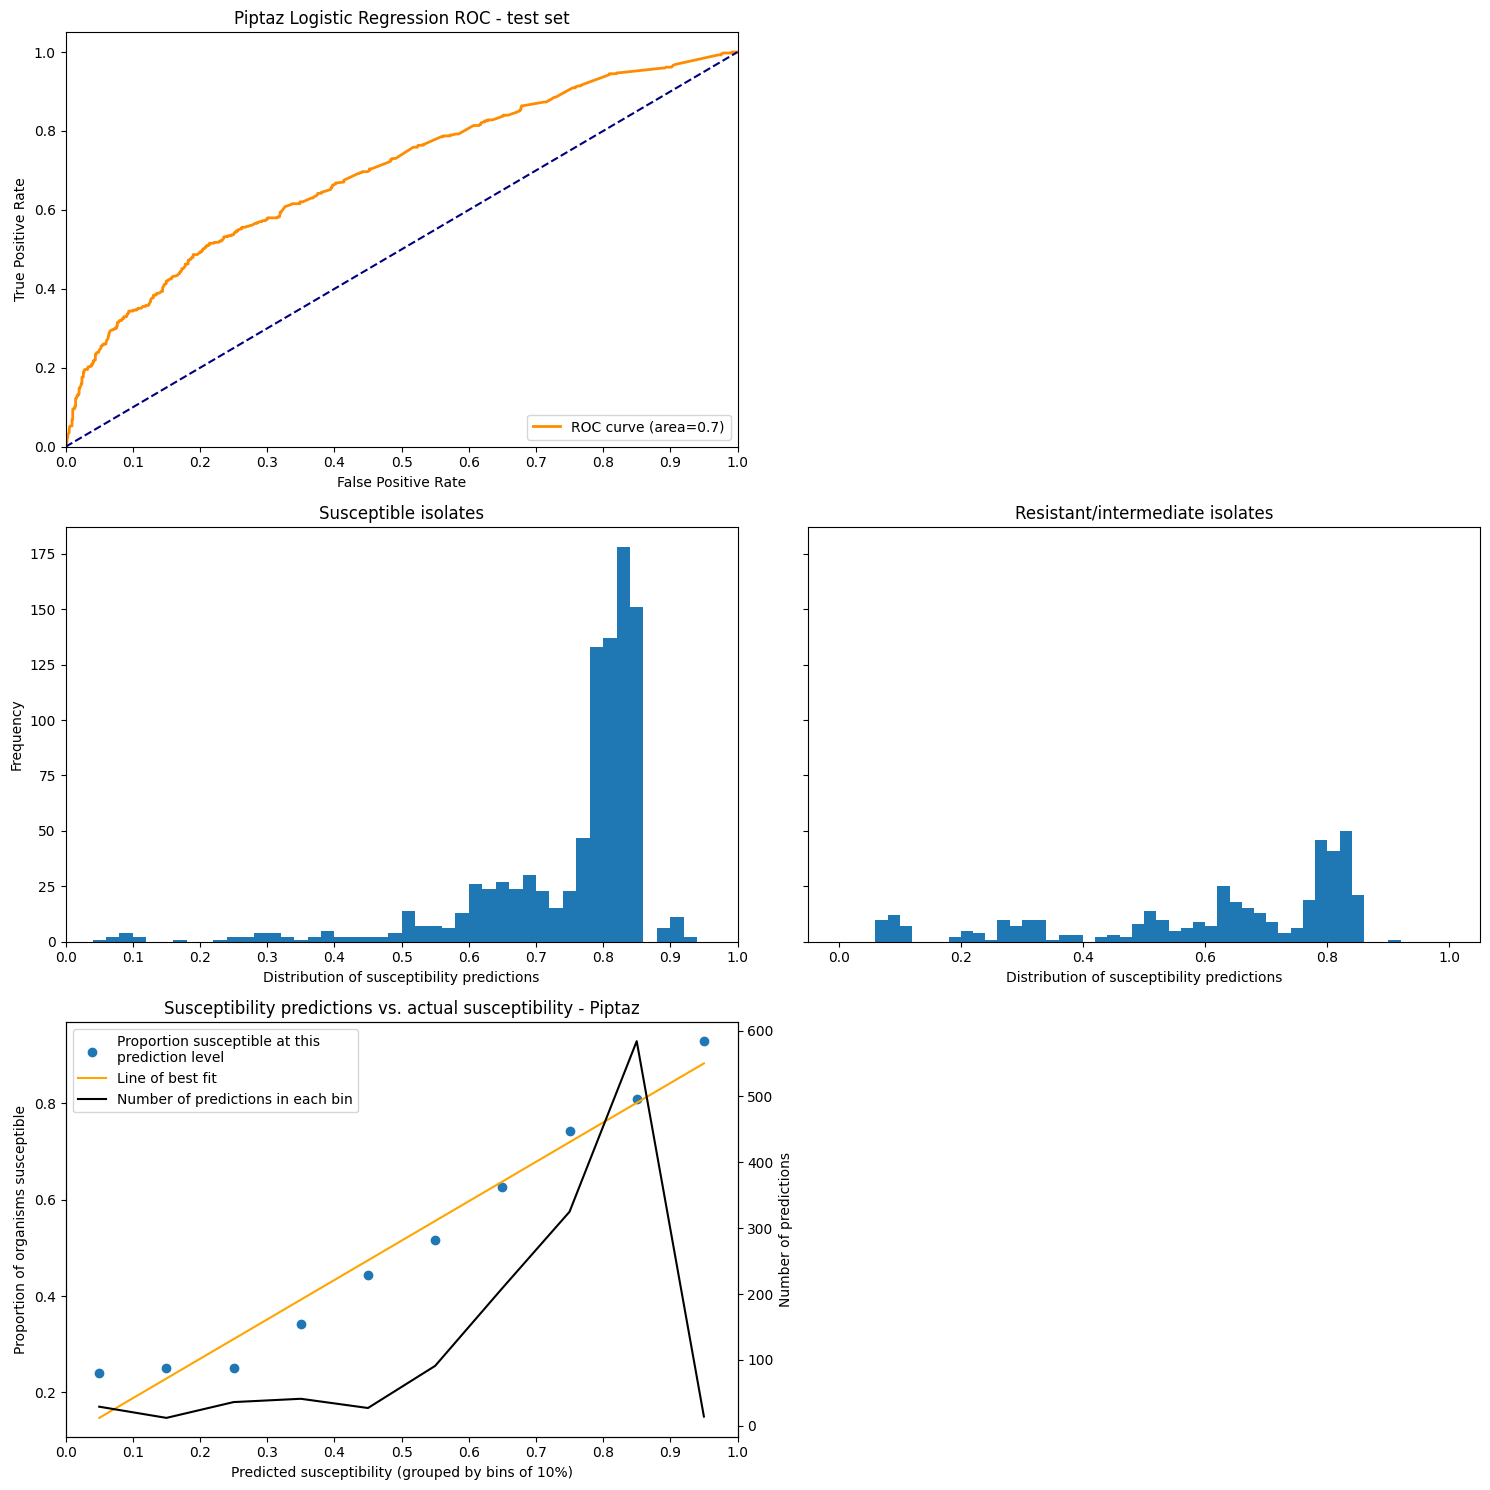


Logistic regression model for Ceftazidime:

Logistic Regression Coefficients
ClinicalESBL                                1.8120
CeftazidimeResistance_nonsusceptible        1.2841
PriorNonCephalosporin                       0.5833
PriorCephalosporin                          0.5635
sex_M                                       0.0841
acquisition_ward                            0.0028
acquisition_ICU                            -0.0019
Age                                        -0.0049
adm_service_surgical                       -0.0418
RecentHospitalization                      -0.1443
CeftazidimeResistance_susceptible          -0.5441

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.09
                     median:  0.88
                     mean:    0.83
                     max:     0.94
                     
Resistant isolates   min:     0.09
                     median:  0.80
                     mean:    0.70
                     max:     0.91
        

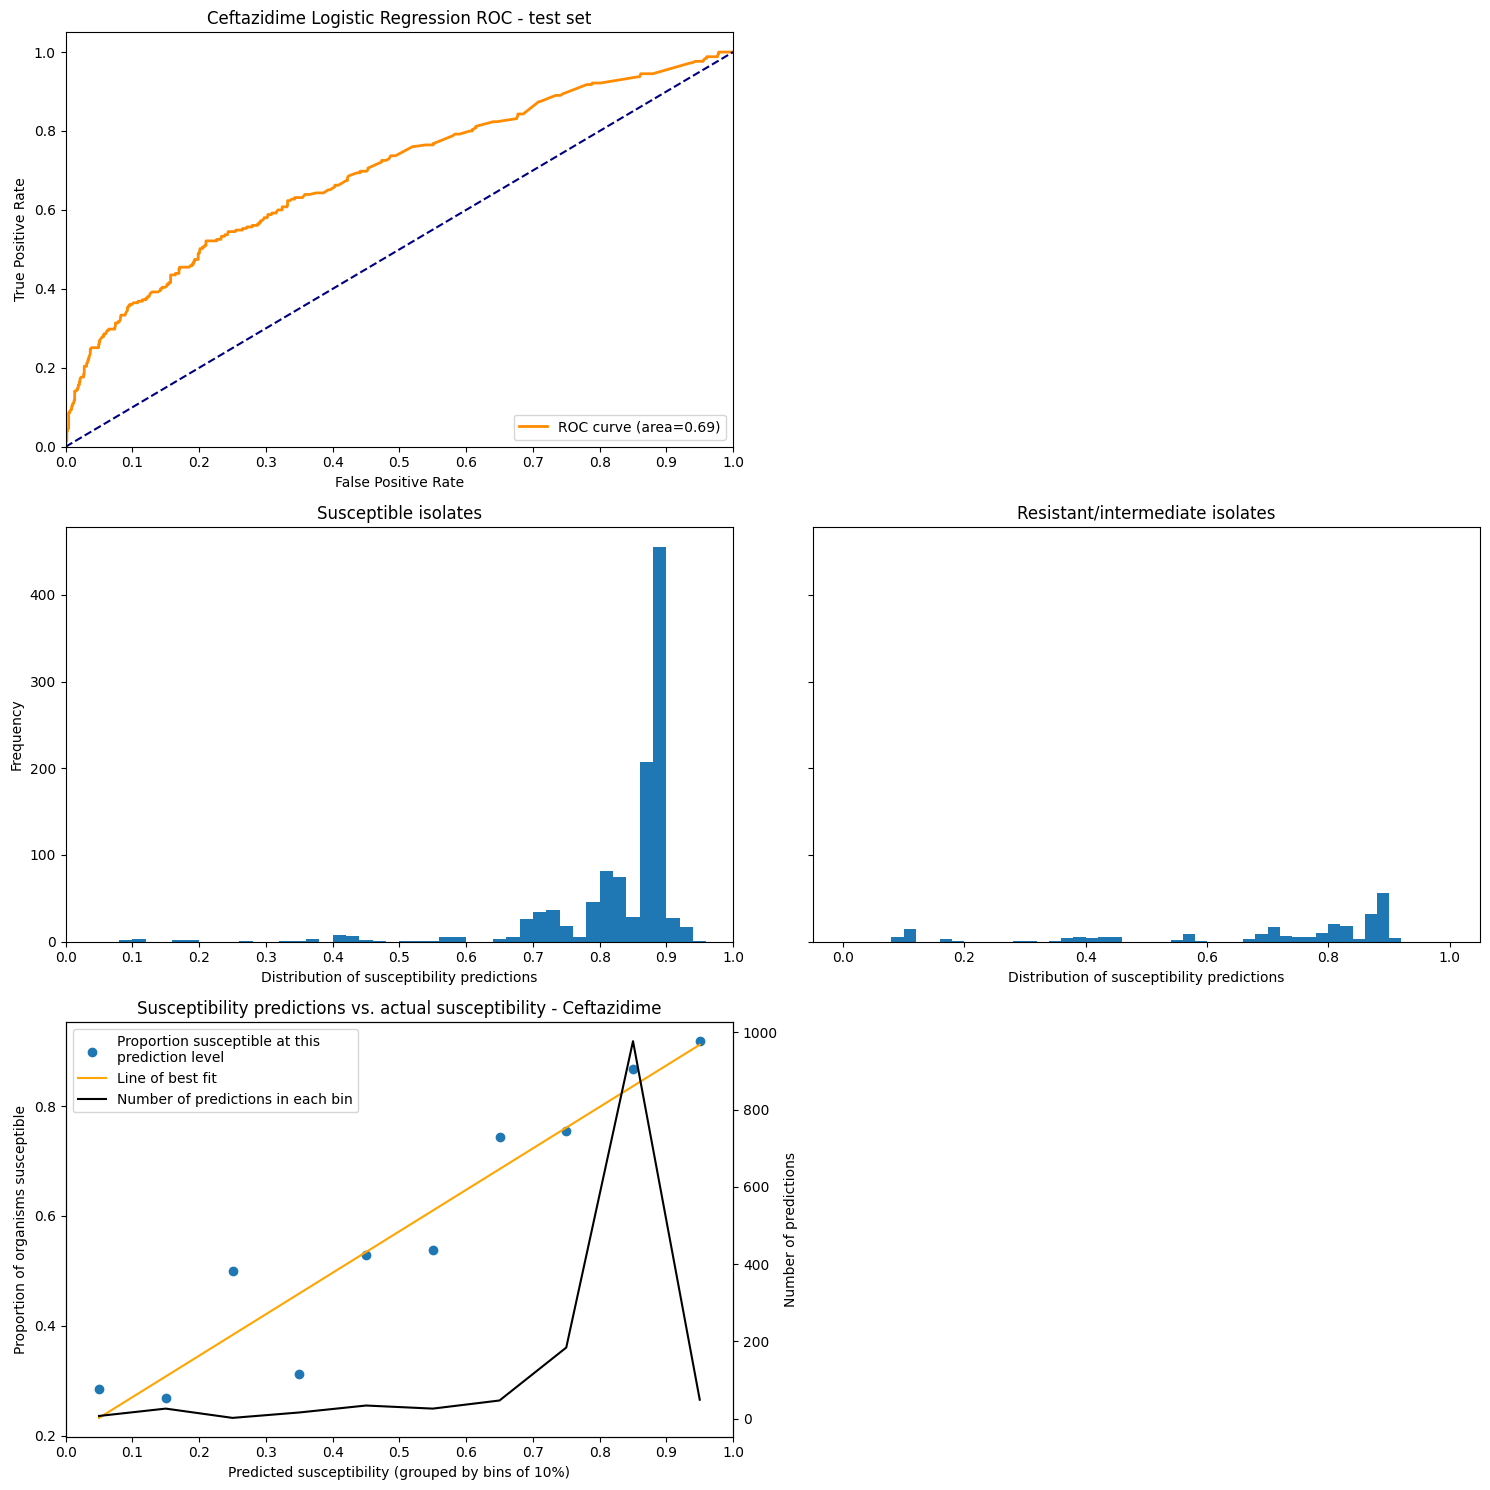


Logistic regression model for Ceftriaxone:

Logistic Regression Coefficients
ClinicalESBL                                1.7172
CeftriaxoneResistance_nonsusceptible        1.3335
PriorCephalosporin                          0.9830
acquisition_ICU                             0.6102
PriorNonCephalosporin                       0.5000
sex_M                                       0.4184
acquisition_ward                            0.1981
adm_service_surgical                        0.0092
Age                                        -0.0077
RecentHospitalization                      -0.1091
CeftriaxoneResistance_susceptible          -0.9147

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.02
                     median:  0.73
                     mean:    0.68
                     max:     0.92
                     
Resistant isolates   min:     0.01
                     median:  0.46
                     mean:    0.46
                     max:     0.84
        

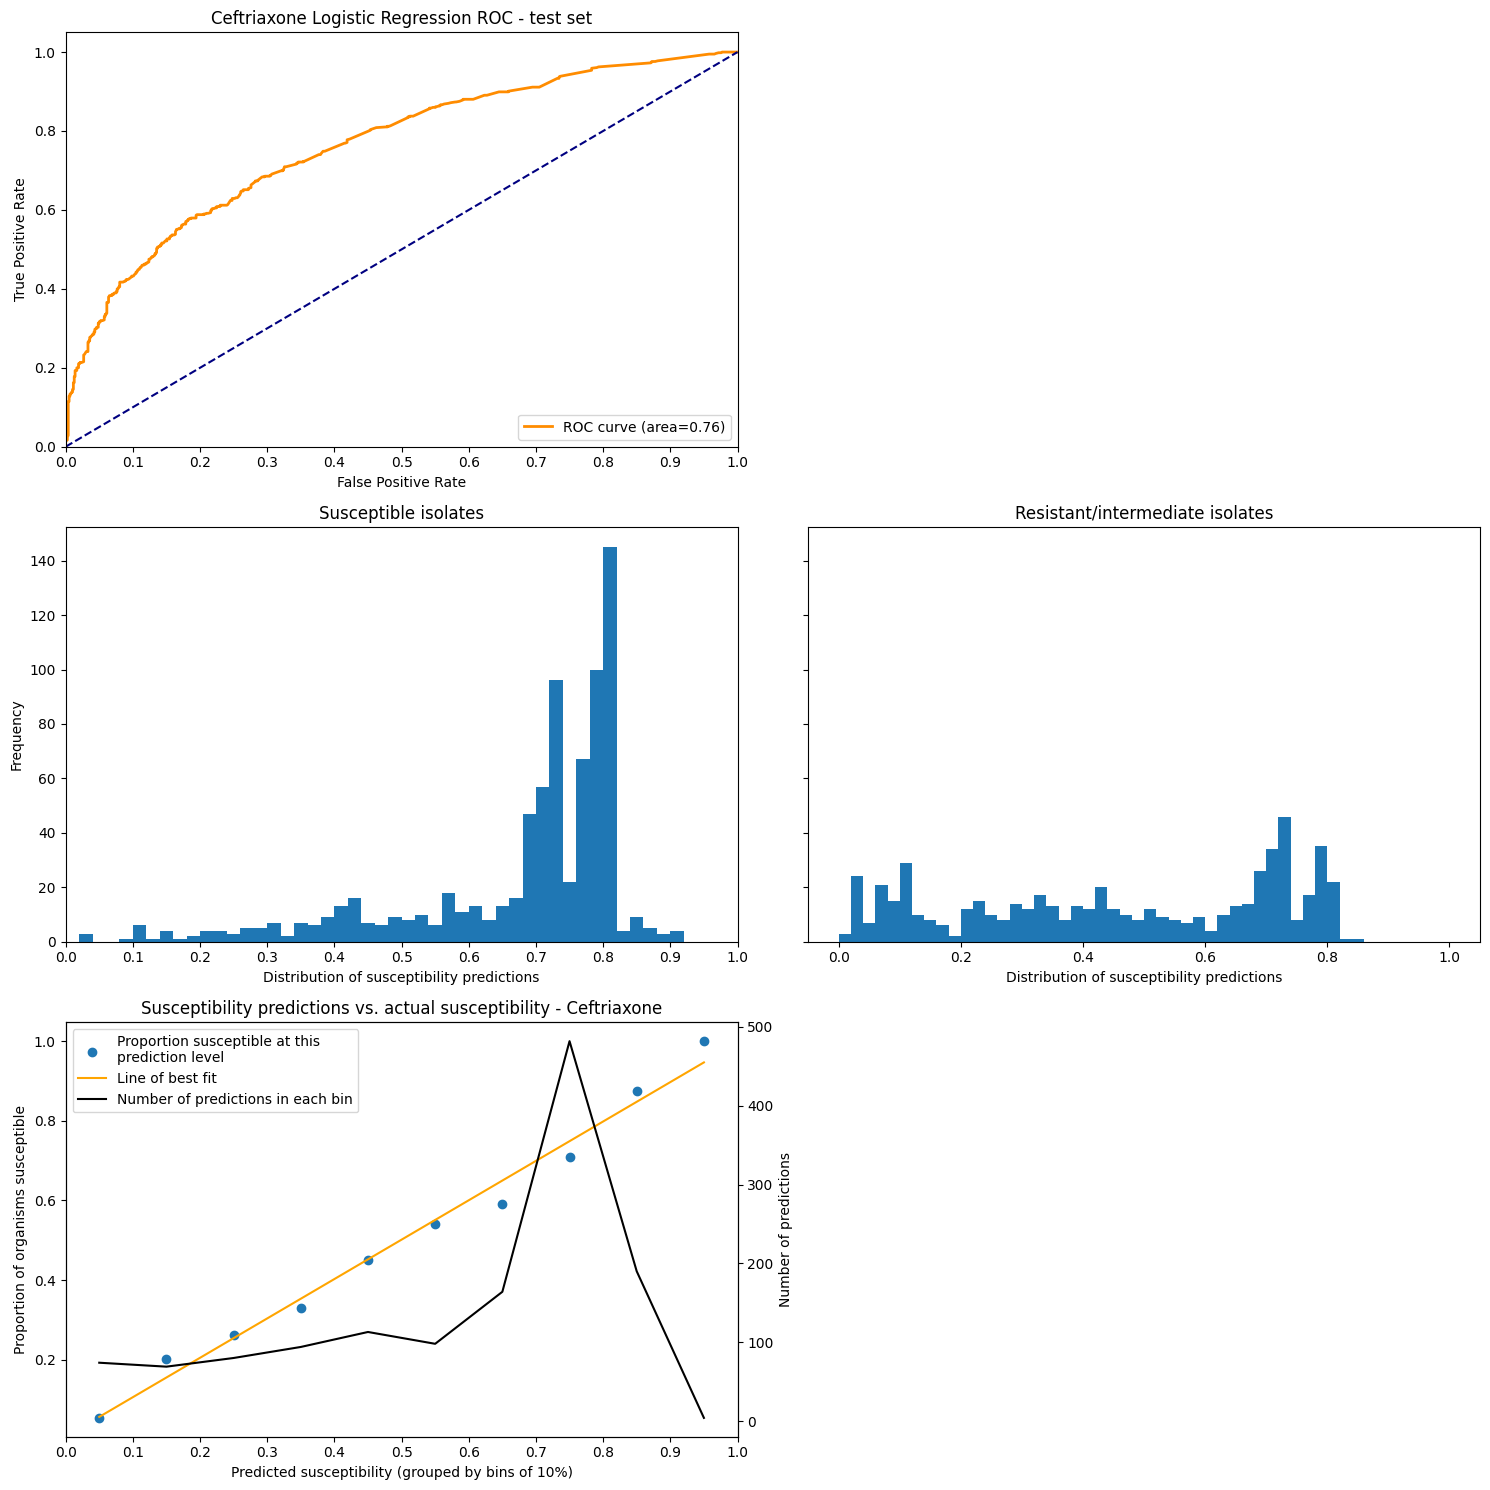


Logistic regression model for Ciprofloxacin:

Logistic Regression Coefficients
ClinicalESBL                                1.5150
CiprofloxacinResistance_nonsusceptible      1.4321
PriorFQ                                     1.0851
PriorNonFQ                                  0.1815
sex_M                                       0.0487
Age                                        -0.0068
adm_service_surgical                       -0.0237
acquisition_ICU                            -0.2000
RecentHospitalization                      -0.2940
acquisition_ward                           -0.3227
CiprofloxacinResistance_susceptible        -0.6867

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.14
                     median:  0.78
                     mean:    0.77
                     max:     0.92
                     
Resistant isolates   min:     0.05
                     median:  0.76
                     mean:    0.67
                     max:     0.92
      

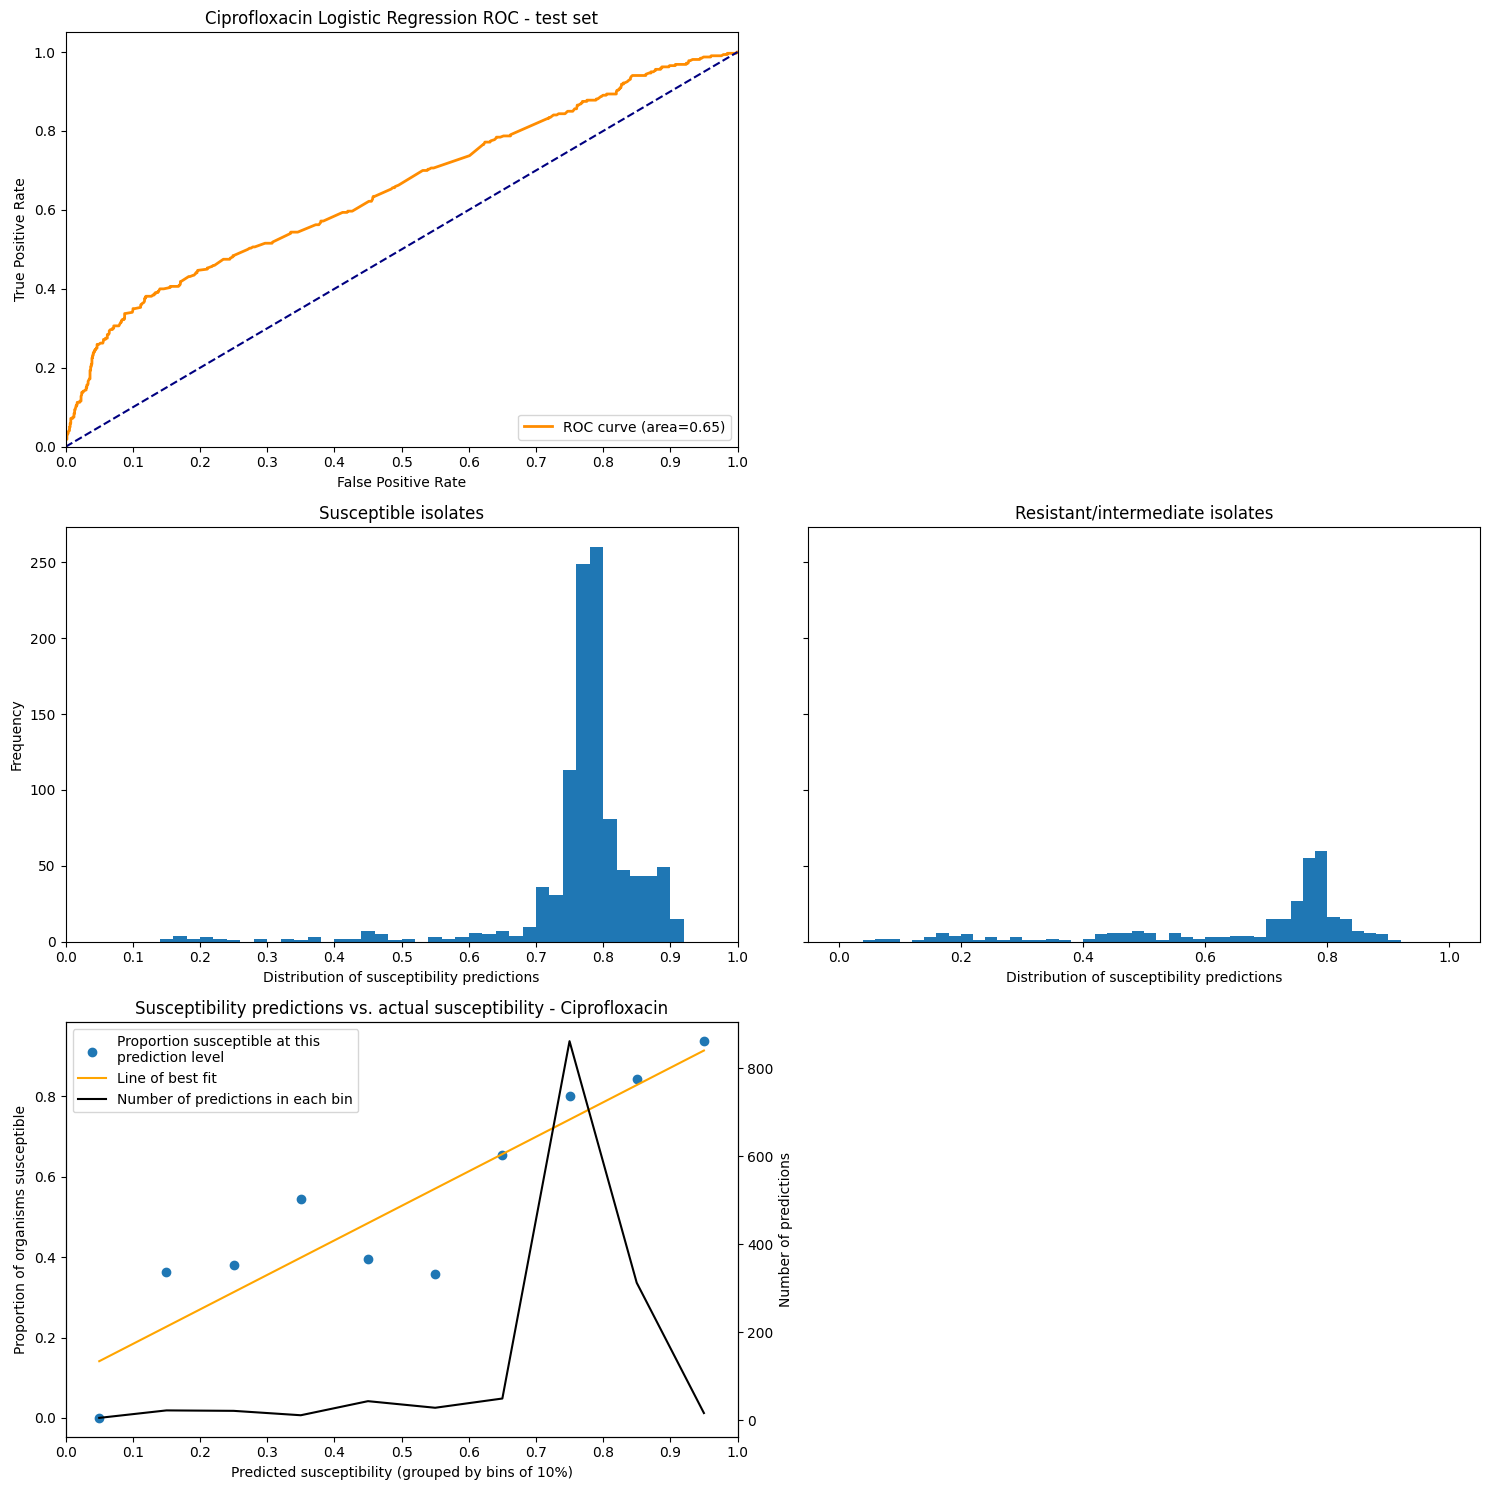

In [15]:
# Divide data into temporal 80-20 train-test sets
# Update 2024-05-23: instead of 80-20 will do 50-50
# Update 2024-06-11: 75-25 split
train_set, test_set= np.split(one_hot_data, [int(.75 *len(one_hot_data))])

# Collect a list of AUCs of the receiver operating characteristic
AUCROCs = []

for antibiotic in antibiotic_list:
    
    print('\nLogistic regression model for {}:\n'.format(antibiotic))
    
    regression_inputs = ['Age','sex_M',                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical','RecentHospitalization',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL'
                        ]
    
    # 0 = susceptible, 1 = resistant
    X_train = train_set[regression_inputs]
    X_test  = test_set [regression_inputs]
    Y_train = train_set[antibiotic+'_FINAL_imp']
    Y_test  = test_set [antibiotic+'_FINAL_imp']
    
    reg = linear_model.LogisticRegression(max_iter=500,penalty=None)
    reg.fit(X_train,Y_train)
    
    # Coefficients sorted by size
    print('Logistic Regression Coefficients')
    for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
        print('{:<42} {: .4f}'.format(i[1],i[0]))

    # Zip together prediction values and actual test values
    # Then sort by susceptible strains first, followed by prediction values
    predict_results = sorted((zip(reg.predict_proba(X_test)[:,0],Y_test)),key=lambda x:(x[1],x[0]))

    # Separate out predictions on susceptible and resistant isolates
    susceptible_isolates = []
    resistant_isolates   = []
    for i in predict_results:
        if i[1]==1:
            resistant_isolates.append(i[0])
        else: susceptible_isolates.append(i[0])

    # Print descriptive statistics
    print('\nProbability of susceptibility: prediction outputs')

    print('''Susceptible isolates min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(susceptible_isolates),
                                np.median(susceptible_isolates),
                                np.mean(susceptible_isolates),
                                max(susceptible_isolates)))    
    print('''Resistant isolates   min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(resistant_isolates),
                                np.median(resistant_isolates),
                                np.mean(resistant_isolates),
                                max(resistant_isolates)))  

    print('Mean predicted susceptibility of all isolates: {:.2f}\n'.format(np.mean(list(i[0] for i in predict_results))))

    print('Intercept: {:.2f}'.format(reg.intercept_[0]))
    
    # Generate plots

    # Calculate and plot ROC based on test set
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,reg.decision_function(X_test))
    AUC = metrics.roc_auc_score(Y_test,reg.decision_function(X_test))

    fig, ax = plt.subplots(nrows=3,ncols=2, 
                           sharex='col',sharey = "row", 
                           figsize=(15,15))

    ax[0,0].plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area={:.2})".format(AUC))

    ax[0,0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,0].set_xlim([0.0, 1.0])
    ax[0,0].set_ylim([0.0, 1.05])
    ax[0,0].xaxis.set_tick_params(labelbottom=True)    
    ax[0,0].set_xlabel("False Positive Rate")
    ax[0,0].set_ylabel("True Positive Rate")
    ax[0,0].set_title("{} Logistic Regression ROC - test set".format(antibiotic))
    ax[0,0].legend(loc="lower right")

    # Calculate and plot ROC based on train set
    fpr, tpr, thresholds = metrics.roc_curve(Y_train,reg.decision_function(X_train))
    AUC = metrics.roc_auc_score(Y_train,reg.decision_function(X_train))
    AUCROCs.append(AUC)

    '''
    # Calculate and plot ROC based on train set    
    ax[0,1].plot(fpr, tpr, color="darkorange", lw=2,
        label="ROC curve (area={:.2})".format(AUC))

    ax[0,1].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,1].set_xlim([0.0, 1.0])
    ax[0,1].set_ylim([0.0, 1.05])
    ax[0,1].set_xticks(np.arange(0,1.1,0.1))
    ax[0,1].xaxis.set_tick_params(labelbottom=True)
    ax[0,1].set_xlabel("False Positive Rate")
    ax[0,1].set_ylabel("True Positive Rate")
    ax[0,1].set_title("{} Logistic Regression ROC - train set".format(antibiotic))
    ax[0,1].legend(loc="lower right")            
    '''
    ax[0,1].axis('off') # Delete this line if we want to see above plot
    
    # Plot a histogram of predictions on susceptible and resistant isolates    
    ax[1,0].hist(susceptible_isolates, bins=50,range=(0,1))    
    ax[1,0].set_title('Susceptible isolates')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].set_xlabel('Distribution of susceptibility predictions')
    ax[1,0].xaxis.set_tick_params(labelbottom=True)    

    ax[1,1].hist(resistant_isolates, bins=50,range=(0,1))
    ax[1,1].set_title('Resistant/intermediate isolates')
    ax[1,1].set_xlabel('Distribution of susceptibility predictions')
    ax[1,1].xaxis.set_tick_params(labelbottom=True)    

    # Divide the predictions into 10 bins, and count the number of predictions for resistant and susceptible in each bin
    print('\n{:<12}  {}  {}  {}'.format('Bin minimum','S count','R count','S percentage'))

    # First, obtain raw prediction or decision function values to create bins
    probability_list = [x[0] for x in predict_results]

    # Create bins of 0.1 each
    hist_edges = np.arange(0,1.05,0.1)

    # For later plotting
    bin_medians = np.arange(0.05,1.05,0.1)
    bin_susceptibilities = []
    bin_counts = [0]*len(bin_medians)

    # Then, loop over bins
    for i in range(len(hist_edges)-1):

        # Count the number of susceptible and resistant predictions in each bin
        susceptible_number = 0
        resistant_number = 0        
        for j in predict_results:
            if j[0]>=hist_edges[i] and j[0]<hist_edges[i+1]:
                if j[1] == 0: susceptible_number +=1
                if j[1] == 1: resistant_number   +=1
                bin_counts[i] += 1

        # Print and plot observations for each bin
        try:
            percent_susceptible = susceptible_number/(resistant_number+susceptible_number)
            print('{:> 11.2f}{:>10}{:>9}{:>14.2f}'.format(hist_edges[i],
                                                          susceptible_number,
                                                          resistant_number,
                                                          percent_susceptible))            
            bin_susceptibilities.append(percent_susceptible)

        except ZeroDivisionError:
            print('{:> 11.2f}{:>10}{:>9}{:>14}'.format(hist_edges[i],susceptible_number,resistant_number,np.nan))
            bin_susceptibilities.append(np.nan)

    print()

    # Plot a scatterplot of binned probabilities and actual susceptibility rates in each bin
    ax2a = ax[2,0]
    ax2b = ax[2,0].twinx()

    ax2a.set_title('Susceptibility predictions vs. actual susceptibility - {}'.format(antibiotic))
    ax2a.set_xlabel('Predicted susceptibility (grouped by bins of 10%)')
    ax2a.set_xticks(np.arange(0,1.1,0.1))
    ax2a.set_ylabel('Proportion of organisms susceptible')

    # Create a bar chart
    ax2b.plot(bin_medians,bin_counts,color='black',label='Number of predictions in each bin')
    ax2b.set_ylabel('Number of predictions')

    # Create a scatter plot
    bin_susceptibilities = np.array(bin_susceptibilities)
    ax2a.scatter(bin_medians,bin_susceptibilities,color='C0',label='Proportion susceptible at this\nprediction level')
    ax2a.set_yticks(np.arange(0,1.1,0.2))    

    # Create a line of best fit
    non_nan_indices = np.isfinite(bin_medians) & np.isfinite(bin_susceptibilities)
    m,b = np.polyfit(bin_medians[non_nan_indices], bin_susceptibilities[non_nan_indices], 1)
    ax2a.plot(bin_medians,m*bin_medians+b,c='orange',label='Line of best fit')    

    # Create a legend
    lines, labels = ax2a.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2a.legend(lines + lines2, labels + labels2, loc='upper left')

    # Delete the bottom right graph and plot the others
    ax[2,1].axis('off')
    fig.patch.set_facecolor('white') # White background for easier copy/pasting
    plt.tight_layout()
    plt.show()

## Writing the regression model (with _all_ data) to file

In [16]:
for antibiotic in antibiotic_list:

    regression_inputs = ['Age','sex_M',
                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical',
                         'RecentHospitalization',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL']

    reg = linear_model.LogisticRegression(max_iter=500,penalty=None)
    reg.fit(one_hot_data[regression_inputs],one_hot_data[antibiotic+'_FINAL_imp'])

    # Print logistic regression coefficients sorted by size
    print('Logistic Regression Coefficients for {}'.format(antibiotic))
    for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
        print('{:<46} {: .4f}'.format(i[1],i[0]))
    print()
    
    # Save the regression model to pickle
    with open(antibiotic+'_Trillium.pickle','wb') as reg_file:
        pickle.dump(reg,reg_file)

Logistic Regression Coefficients for Meropenem
MeropenemResistance_nonsusceptible              2.3542
acquisition_ICU                                 1.4642
PriorCarbapenem                                 1.3370
acquisition_ward                                1.0666
PriorNonCarbapenem                              0.7897
sex_M                                           0.2717
RecentHospitalization                           0.0151
Age                                            -0.0135
ClinicalESBL                                   -0.0898
MeropenemResistance_susceptible                -0.2066
adm_service_surgical                           -0.4800

Logistic Regression Coefficients for Piptaz
ClinicalESBL                                    1.5139
PiptazResistance_nonsusceptible                 1.2411
PriorNonPenicillin                              0.7671
acquisition_ICU                                 0.3766
sex_M                                           0.2723
PriorPenicillin             

## Quality assurance of the model on previous isolates

In [17]:
for antibiotic in antibiotic_list:
    with open(antibiotic+'_Trillium.pickle','rb') as f:
        reg = pickle.load(f)

    regression_inputs = ['Age','sex_M',
                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical',
                         'RecentHospitalization',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL']
    
    regression_values = one_hot_data[regression_inputs]

    one_hot_data['Predicted'+antibiotic+'Susceptibility'] = reg.predict_proba(regression_values)[:,0]


# QA_data = original_data.join(one_hot_data[['Predicted'+antibiotic+'Susceptibility' for antibiotic in antibiotic_list]])

date = datetime.today().strftime('%Y-%m-%d')
one_hot_data.to_excel(date+' QA data_Trillium.xlsx',freeze_panes=(1,0),index=False)
